In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
from datetime import datetime

## Data Cleaning

In [2]:
data_raw = pd.read_csv('Dataset1_Version1.csv', sep=';')

In [3]:
new_df = data_raw.dropna(subset=['ObjektNr'])

In [4]:
pd.set_option('display.max_rows', None)

In [5]:
duplicate_values = new_df['ObjektNr'].duplicated()
#print(duplicate_values)

In [6]:
columns_to_convert = ['BuchungenGenormt', 'ZeitGenormt', 'BewertungGenormt', 'CancelQuote']

In [7]:
new_df[columns_to_convert] = new_df[columns_to_convert].apply(lambda x: x.str.replace(',', '.').astype(float))

/Users/imamalvarogarcia/miniforge3/envs/pylabfea/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


## Classify Data

In [8]:
filtered_df_priority = new_df[(new_df['BuchungenGenormt'] > 80) & 
                 (new_df['ZeitGenormt'] < 20) & (new_df['BewertungGenormt'] > 80) & (new_df['CancelQuote'] < 2)]

In [9]:
filtered_df_priority

,ObjektNr,lastBooking,BuchungenGenormt,ZeitGenormt,BewertungGenormt,CancelQuote
0,456806.0,18.08.2023,100.0,6.5,93.8,0.91


In [10]:
def classifying_percolumn(data, column_name='BuchungenGenormt', f=-1, e=40, d=70, max_val=100):
    try:
        bins = [f, e, d, max_val]
        new_data = data.copy()
        
        new_data['class'] = pd.cut(new_data[column_name],
                                    bins=bins,
                                    labels=[f'Class{n}' for n in range(len(bins) - 1, 0, -1)])
        return new_data
    except Exception as ex:
        raise ex

In [11]:
def classify_hotels(data):
    # Assign weights to parameters
    weights = {
        'BuchungenGenormt': 0.4,
        'BewertungGenormt': 0.3,
        'CancelQuote': 0.2,  
        'ZeitGenormt': 0.1
    }

    new_data = data.copy()
    
    new_data['weighted_sum'] = (new_data['BuchungenGenormt'] * weights['BuchungenGenormt'] +
                            new_data['BewertungGenormt'] * weights['BewertungGenormt'] +
                            (100 - new_data['CancelQuote']) * weights['CancelQuote'] +
                            (100 - new_data['ZeitGenormt']) * weights['ZeitGenormt'])

    # Define classification thresholds
    
    max_val = 100
    d = 80
    e = 60
    f = -1
    bins = [f, e, d, max_val]

    # Classify hotels based on the weighted sum
    new_data['classification'] = pd.cut(new_data['weighted_sum'],
                                    bins=bins,
                                    labels=[f'Class{n}' for n in range(len(bins) - 1, 0, -1)])

    return new_data

classified_df = classify_hotels(new_df)

In [12]:
#classified_df

In [13]:
booking_number_classification = classifying_percolumn(new_df, column_name = 'BuchungenGenormt')

In [14]:
#booking_number_classification

In [15]:
time_classification = classifying_percolumn(new_df, column_name = 'ZeitGenormt',f=-1, e=10, d=70, max_val=100)

In [16]:
#time_classification

In [17]:
review_classification = classifying_percolumn(new_df, column_name = 'BewertungGenormt')

In [18]:
cancel_classification = classifying_percolumn(new_df, column_name = 'ZeitGenormt',f=-1, e=10, d=70, max_val=100)

In [19]:
#cancel_classification

In [20]:
new_df_nan = new_df[:20727]

In [21]:
average_values = new_df_nan[columns_to_convert].mean()
print(average_values)

BuchungenGenormt     3.073238
ZeitGenormt         16.176509
BewertungGenormt    57.304501
CancelQuote          9.373708
dtype: float64


In [22]:
filtered_df_priority_average = new_df[(new_df['BuchungenGenormt'] > 65) & 
                 (new_df['ZeitGenormt'] < 16) & (new_df['BewertungGenormt'] > 56) & (new_df['CancelQuote'] < 9)]

In [23]:
filtered_df_highBN_highCQ = new_df[(new_df['BuchungenGenormt'] > 70) & (new_df['CancelQuote'] > 1)]

In [24]:
filtered_df_highBN_highCQ

,ObjektNr,lastBooking,BuchungenGenormt,ZeitGenormt,BewertungGenormt,CancelQuote
1,346177.0,22.07.2023,81.42,41.0,89.0,2.74
4,158996.0,17.08.2023,70.41,23.5,94.2,1.29


In [25]:
filtered_df_highBN_highZG = new_df[(new_df['BuchungenGenormt'] > 70) & (new_df['ZeitGenormt'] > 20)]

In [26]:
filtered_df_booking_and_review = new_df[(new_df['BuchungenGenormt'] < 56) & 
                 (new_df['BewertungGenormt'] > 80 )]

### Kurzaufnahme
1. Kunde = Webbesucher, Partner = Hotelbesitzer
2. Klassifizierung basierend auf allen Parametern mit Gewichtungsfaktor kann verwendet werden, um dem Kunden eine Empfehlung zu geben (Stempel auf dem Web/App setzen)
3. Die Klassifizierung nach Parametern ermöglicht es uns, das Problem genauer zu verstehen, z. B. können wir untersuchen, warum das Hotel nur langsam reagiert oder warum es eine höhere Stornoquote hat. Außerdem können wir den Hotelbesitzer belohnen, der einen höheren Rang bei der Buchungszahl und der Bewertung hat (z.B. "Approved by ...")
4. Wenn wir ein Hotel finden, das eine hohe Buchungszahl, aber eine hohe Stornoquote hat, können wir den Partner fragen, was der Grund dafür ist, und ihm wahrscheinlich helfen, das Problem zu lösen. Wenn ein Hotel eine niedrige Buchungszahl, aber eine gute Bewertung hat, können wir ihm helfen, in unserem Web/App zu werben (wir können Einnahmen aus ihren Anzeigen erzielen), usw. 

## Working with Last Booking

In [27]:
new_df['lastBooking'] = pd.to_datetime(new_df['lastBooking'], format='%d.%m.%Y')

condition = (new_df['BuchungenGenormt'] > 70) & (new_df['BewertungGenormt'] > 70)

filtered_df = new_df[condition]

sorted_df = filtered_df.sort_values(by='lastBooking', ascending=True)

hotel_with_longest_booking = sorted_df.iloc[0]['ObjektNr']

print(f"The hotel with the longest last booking from today but has high 'BuchungenGenormt' and 'BewertungGenormt' is: {hotel_with_longest_booking}")


The hotel with the longest last booking from today but has high 'BuchungenGenormt' and 'BewertungGenormt' is: 1554762.0


<ipython-input-27-2181aaad5964>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['lastBooking'] = pd.to_datetime(new_df['lastBooking'], format='%d.%m.%Y')


In [28]:
new_df_nan['Month'] = new_df['lastBooking'].dt.month

most_frequent_month = new_df_nan['Month'].mode()[0]

print("Most Frequent Month:", most_frequent_month)
print("Least Frequent:", new_df_nan['Month'].value_counts().index[-1])

Most Frequent Month: 8.0
Least Frequent: 12.0


<ipython-input-28-2fe0c0de628a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_nan['Month'] = new_df['lastBooking'].dt.month


<AxesSubplot:>

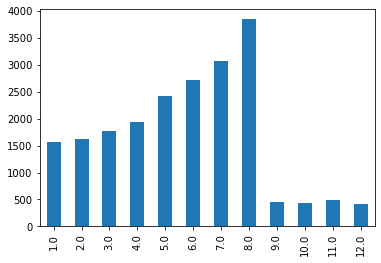

In [29]:
new_df_nan['Month'].value_counts().sort_index().plot(kind='bar')

In [30]:
new_df_nan['Year'] = new_df['lastBooking'].dt.year

most_frequent_year = new_df_nan['Year'].mode()[0]

print("Most Frequent Year:", most_frequent_year)

Most Frequent Year: 2023.0


<ipython-input-30-a02d9e079bd4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_nan['Year'] = new_df['lastBooking'].dt.year


<AxesSubplot:>

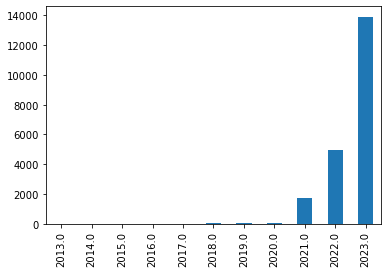

In [31]:
new_df_nan['Year'].value_counts().sort_index().plot(kind='bar')

In [32]:
new_df_2023 = new_df[new_df['lastBooking'].dt.year == 2023]

# Count occurrences of each month
month_counts_2023 = new_df_2023['lastBooking'].dt.month.value_counts()

<AxesSubplot:>

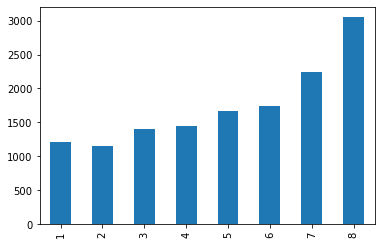

In [33]:
new_df_2023['lastBooking'].dt.month.value_counts().sort_index().plot(kind='bar')

### Kurze Aufnahme
1. Nach August ist der Trend rückläufig
2. Aus den Daten geht hervor, dass von Januar bis August die Last Booking höher ist. Wir können versuchen, im Dezember zu werben, um Leute anzusprechen, die in diesen Monaten Urlaub machen wollen.
3. Wir können auch unsere Partner informieren, um ihnen zu sagen, dass sie sich auf die Hochsaison vorbereiten sollen.
4. Für September bis Dezember können wir einen "Köder" wie z.B. einen Rabatt anbieten, um die Nachfrage zu erhöhen.
5. Pro Jahr ist die Grafik 2023 höher. Könnte am Covid liegen, 2021 - 2022 ist noch Erholungszeit für die Urlaubssaison
5. Da dies jedoch die "last booking" ist, können wir nicht wirklich sicher sein, denn es könnte sein, dass jemand, der 2023 gebucht hat, auch 2022 gebucht hat, dies aber nicht in 2022 erfasst wurde. Wir brauchen "new booking", damit wir die Nachfrage genau kennen.

## Find relation between parameter with booking number

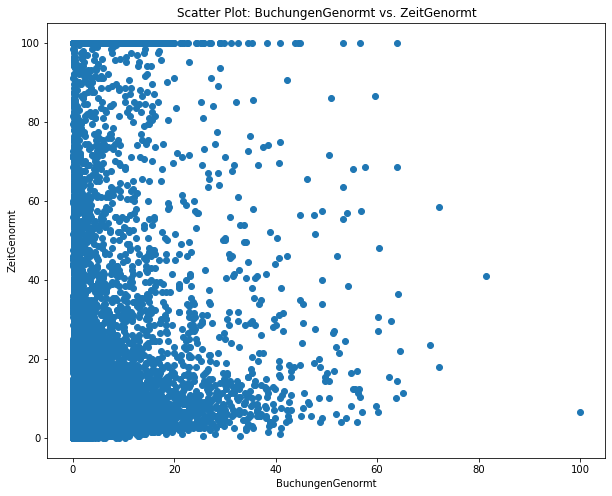

In [34]:
def plot_data(data, x_column, y_column):
    plt.figure(figsize=(10, 8))
    plt.scatter(data[x_column], data[y_column])
    plt.title(f'Scatter Plot: {x_column} vs. {y_column}')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.show()

plot_data(new_df, x_column='BuchungenGenormt', y_column='ZeitGenormt')

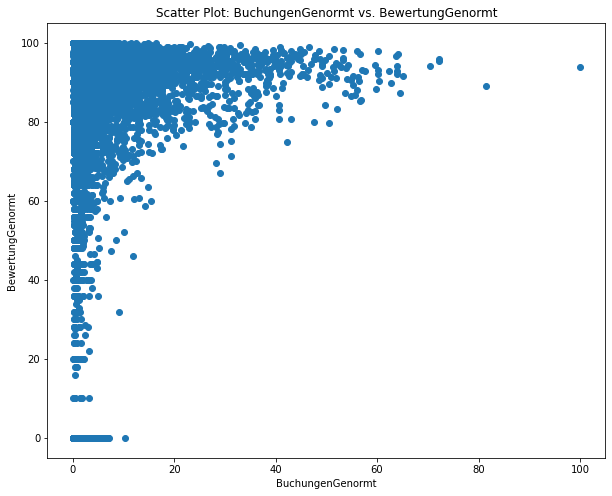

In [35]:
plot_data(new_df, x_column='BuchungenGenormt', y_column='BewertungGenormt')

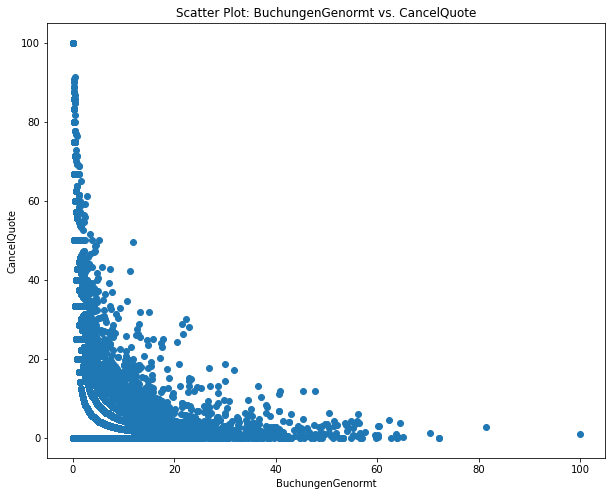

In [36]:
plot_data(new_df, x_column='BuchungenGenormt', y_column='CancelQuote')

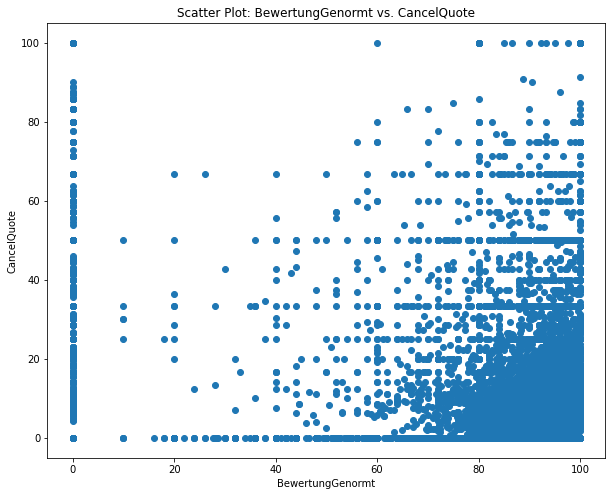

In [37]:
plot_data(new_df, x_column='BewertungGenormt', y_column='CancelQuote')

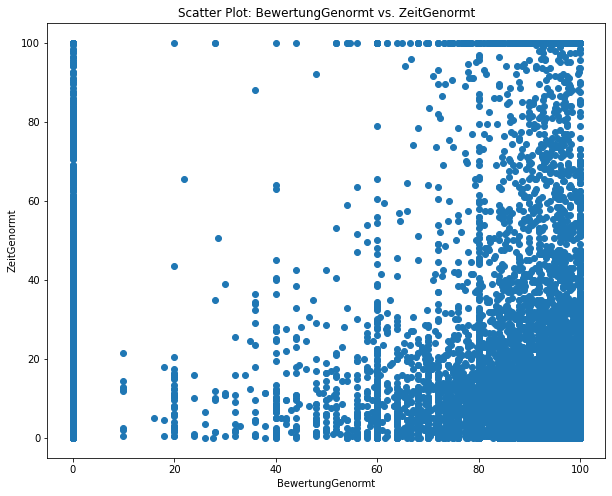

In [38]:
plot_data(new_df, x_column='BewertungGenormt', y_column='ZeitGenormt')

### Kurze Aufnahme
1. Je besser die Bewertung, desto höher die Buchungszahl. Wir können an der Bewertung arbeiten, arbeiten Sie mit dem Partner zusammen.
2. Je niedriger die Stornoquote, desto höher die Buchungszahl. Wir können mit dem Partner zusammenarbeiten, um ihm zu helfen, die Stornoquote zu senken.

## Anregung
1. Wir können eine Heatmap basierend auf dem Standort haben, so dass wir wissen, in welchem Monat welches Gebiet (Schweiz, Deutschland) eine höhere Buchungszahl hat
2. Neue Buchungszahlen zu haben, um genau die Nachfrage zu kennen. 